# 1) Background

## Problem:

If a researcher is working with longitudinal or panel data, he or she may want to detect latent groupings or clusters in these data. Specifically, for life-course approaches to research, you may want to identify latent trajectories of a behavior or outcome across time.


## Outline of Algorithm: 

The paper I have chosen describes a type of finite mixture algorithm, one for modeling patterns of an outcome of interest as clusters across time. The method is termed by the authors as Group-based Latent Trajectory Modeling, and was developed by Daniel Nagin in 1999.

The general specification for the group based latent trajectory models is provided in equations (1) and (2). Equation (1) describes the basic form of the finite mixture model--i.e., summing a finite number of latent groupings believed to compose the underlying population. Since group membership is not observed, the proportion of the $j$ underlying population belonging to each of the latent trajectory groups $\pi_j$, must be estimated. This requires the aggregation of the $J$ conditional likelihood functions, forming the unconditional probability of the data, $Y_i$ (Nagin 2005).


$$P(Y_i) = \sum_{j}^J \pi_j P^j (Y_i)\tag{1}$$ 

Here, $P(Y_i)$ estimates the unconditional probability of seeing the trajectory of the outcome measure for individual $i$. 

The key to the "group-based" approach is an underlying idea called "conditional independence." The likelihood function this produces is denoted in equation (2). For a give group $j$, conditional independence makes the assumption that the distribution of $y_{it}$ is independent of the observed value of the outcome in prior periods, $y_{it-1}$,  $y_{it-2}$,... This assumption helps to reduce the complexity of the model, and when combined with the EM algorithm, allows for identification of latent trajectory groupings despite the complex nature of the model and data.

$$L = \prod^N P(Y_i)\tag{2}$$


## Readme for Python Module: 

### Group-Based Finite Mixture Models: A Latent Trajectory Approach 

**Code for course project use only at this time.**

Final project for STA 663 
* Takes time variable and continuous outcome 
* Generates latent trajectories (time-dependent clusters) of outcome behavior over time 

**Dependencies**

Required

* Python (created using 2.7.x)
* Numpy
* Scipy 
* Pymix (https://github.com/klahnakoski/pymix.git)

Recommended

* ggplot (for trajectory plotting function included in the repository)
* pandas (for trajectory plotting function included in the repository)
* STAN (for Bayesian alternative specification)
* pystan (for Bayesian alternative specification)
* rpy2 (for loading in test data from R)

# 2) Implementation

*Note: I had started to build these distribution functions myself 
(see py scripts in GitHub repo)
but then I discovered a python library with mixture distributions
that could be combined and reshaped to estimate these models ('Pymix' package)!*

In [78]:
from __future__ import division
import os
import sys
import glob
from mixture import *
import mixture
import numpy as np
import pandas as pd
from ggplot import *
import pandas as pd
import pystan
%matplotlib inline
%precision 4
%load_ext rpy2.ipython

np.random.seed(34)

# ------- #
# Normal Mixture #
# ------- #
# Normal Distribution Functions 

# Generate Means of Normal Mixture
def norm_means(data): 
    cols = data.shape[1]
    return np.repeat(0.0,cols) 

# Generate Covariance Structure of Normal Mixture based on conditional independence assumption
# (See Equation (2) in outline of algorithm)
def norm_cov(data):
    m = data.shape[1]
    covs = np.repeat(1.0,m) 
    return np.diag(covs)

# Single Multivariate Normal distribution function
def norm_singdist(ng, data):
    m = data.shape[1]
    dist = mixture.MultiNormalDistribution(m, 
        norm_means(data),norm_cov(data))
    return dist

# Generalize to multiple clusters of multivariate distribution function
def norm_multdist(ng, data):
    temp = list()
    for x in range(ng):
        temp.append(norm_singdist(2, data))
    return temp

# Data functions
def build_mix_dat(data):
    mixdat = mixture.DataSet()
    mixdat.fromArray(data)
    return mixdat

# Normal Mixture Model 
def intialize_normal_model(ng, data):
    mod_ps = np.repeat(1.0/ng, ng)
    if ng ==2:
        n1,n2 = norm_multdist(ng, data)
        mix_ = mixture.MixtureModel(ng, mod_ps,[n1,n2])
    elif ng == 3:  
        n1,n2,n3 = norm_multdist(ng, data)
        mix_ = mixture.MixtureModel(ng, mod_ps,[n1,n2,n3])
    elif ng == 4:  
        n1,n2,n3,n4 = norm_multdist(ng, data)
        mix_ = mixture.MixtureModel(ng, mod_ps,[n1,n2,n3,n4])
    elif ng == 5:  
        n1,n2,n3,n4,n5 = norm_multdist(ng, data)
        mix_ = mixture.MixtureModel(ng, mod_ps,[n1,n2,n3,n4,n5])
    elif ng == 6:  
        n1,n2,n3,n4,n5,n6 = norm_multdist(ng, data)
        mix_ = mixture.MixtureModel(ng, mod_ps,[n1,n2,n3,n4,n5,n6])
    elif ng == 7:  
        n1,n2,n3,n4,n5,n6,n7 = norm_multdist(ng, data)
        mix_ = mixture.MixtureModel(ng, mod_ps,[n1,n2,n3,n4,n5,n6,n7])
    elif ng == 8:  
        n1,n2,n3,n4,n5,n6,n7,n8 = norm_multdist(ng, data)
        mix_ = mixture.MixtureModel(ng, mod_ps,[n1,n2,n3,n4,n5,n6,n7,n8])
    return mix_ 

# Run Normal Mixture Model
def normal_mixmod(ng, data, s=0):
    mix_mod = intialize_normal_model(ng, data)
    mix_dat = build_mix_dat(data)
    mix_mod.modelInitialization(mix_dat)
    mix_mod.EM(mix_dat, 40,.2, silent=s)
    mix_mod.classify(mix_dat, silent=s)
    return mix_mod
   
# Results 
def GBFMM(ng,data, s=0): 
    out = normal_mixmod(ng, data, s=s)
    traj = list()
    for i in range(ng):
        traj.append(out.components[i].distList[0].mu)
    return traj

# Trajectory Plotting Function
def plot_traj(outs):
    if len(outs) == 2:
        d = {'one' : outs[0], 
        'two' : outs[1], 
        'Time': range(1,len(outs[0])+1)}
    elif len(outs) == 3:
        d = {'one' : outs[0], 
        'two' : outs[1], 
        'three' : outs[2], 
        'Time': range(1,len(outs[0])+1)}
    elif len(outs) == 4: 
        d = {'one' : outs[0], 
        'two' : outs[1], 
        'three' : outs[2], 
        'four' : outs[3], 
        'Time': range(1,len(outs[0])+1)}
    elif len(outs) == 5:
        d = {'one' : outs[0], 
        'two' : outs[1], 
        'three' : outs[2], 
        'four' : outs[3], 
        'five' : outs[4], 
        'Time': range(1,len(outs[0])+1)}
    elif len(outs) == 6:
        d = {'one' : outs[0], 
        'two' : outs[1], 
        'three' : outs[2], 
        'four' : outs[3], 
        'five' : outs[4], 
        'six' : outs[5], 
        'Time': range(1,len(outs[0])+1)}
    elif len(outs) == 7: 
        d = {'one' : outs[0],
        'two' : outs[1], 
        'three' : outs[2], 
        'four' : outs[3], 
        'five' : outs[4], 
        'six' : outs[5], 
        'seven' : outs[6], 
        'Time': range(1,len(outs[0])+1)}
    elif len(outs) == 8:
        d = {'one' : outs[0],
        'two' : outs[1], 
        'three' : outs[2], 
        'four' : outs[3], 
        'five' : outs[4], 
        'six' : outs[5], 
        'seven' : outs[6], 
        'eight' : outs[7], 
        'Time': range(1,len(outs[0])+1)}
    dat = pd.DataFrame(d) 
    dm = pd.melt(dat, id_vars=['Time'], var_name='Latent Class', value_name='Value') 
    print ggplot(dm, aes('Time', 'Value', color='Latent Class')) + \
        geom_point(size=80) + \
        geom_line(size=3) + \
        theme_bw()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# 3) Testing

In [25]:
# ----------- #
# Tests for convergence given mixture distributions with given number of groupings
# (these also test that the number of latent groups produced equal the number of groups specified)
# test_numgroups_3
# ----------- #
dist3 = MultiNormalDistribution(3, [0.0, 1.0, 3.0], 
                    [[1.0, 0.1, 0.14], 
                     [0.2, 1.0, 0.2], 
                     [0.3, 0.2, 1.0]])
data3 = dist3.sampleSet(100)
assert len(GBFMM(ng=3, data=data3, s=1)) == 3
 
# test_numgroups_4
dist4 = MultiNormalDistribution(4, [0.0, 1.0, 3.0,2.0], 
                    [[1.0, 0.1, 0.14,0.2], 
                     [0.2, 1.0, 0.2,0.4], 
                     [0.3, 0.2, 1.0,0.3], 
                     [0.3, 0.2, 0.3,1.0]])
data4 = dist4.sampleSet(100)
assert len(GBFMM(ng=4, data=data4, s=1)) == 4

# test_numgroups_5
dist5 = MultiNormalDistribution(5, [0.0, 1.0, 3.0,2.0,0.5], 
                    [[1.0, 0.1, 0.14,0.2,0.1], 
                     [0.2, 1.0, 0.2,0.4,0.35], 
                     [0.3, 0.2, 1.0,0.3,0.05], 
                     [0.3, 0.2, 0.3,1.0,0.32], 
                     [0.1, 0.22,0.08,.15,1.0]])
data5 = dist5.sampleSet(100)
assert len(GBFMM(ng=5, data=data5, s=1)) == 5

# test_numgroups_6
dist6 = MultiNormalDistribution(6, [0.0, 1.0, 3.0,2.0,0.5,1.5], 
                    [[1.0, 0.1, 0.14,0.2, 0.1, 0.6], 
                     [0.2, 1.0, 0.2, 0.4, 0.35,0.2], 
                     [0.3, 0.2, 1.0, 0.3, 0.05,0.0], 
                     [0.3, 0.2, 0.3, 1.0, 0.32,0.1], 
                     [0.1, 0.22,0.08,0.15,1.0, 0.25],
                     [0.2, 0.1, 0.2, 0.4, 0.35,1.0]])
data6 = dist6.sampleSet(1000)
assert len(GBFMM(ng=6, data=data6, s=1)) == 6

# test_numgroups_7
dist7 = MultiNormalDistribution(7, [0.0, 1.0, 3.0,2.0,0.5,1.5,-1.0], 
                    [[1.0, 0.1, 0.14,0.2, 0.1, 0.6,0.25], 
                     [0.2, 1.0, 0.2, 0.4, 0.35,0.2, 0.2], 
                     [0.3, 0.2, 1.0, 0.3, 0.05,0.0, 0.3], 
                     [0.3, 0.2, 0.3, 1.0, 0.32,0.1, 0.2], 
                     [0.1, 0.22,0.08,0.15,1.0, 0.25,0.1],
                     [0.2, 0.1, 0.2, 0.4, 0.35,1.0, 0.0], 
                     [0.1, 0.22,0.08,0.15,0.2, 0.15,1.0]])
data7 = dist7.sampleSet(1000)
assert len(GBFMM(ng=7, data=data7, s=1)) == 7

# test_numgroups_8
dist8 = MultiNormalDistribution(8, [0.0, 1.0, 3.0,2.0,0.5,1.5,-1.0,1.0], 
                    [[1.0, 0.1, 0.14,0.2, 0.1, 0.6,0.25,0.2], 
                     [0.2, 1.0, 0.2, 0.4, 0.35,0.2, 0.2,0.1], 
                     [0.3, 0.2, 1.0, 0.3, 0.05,0.0, 0.3,0.2], 
                     [0.3, 0.2, 0.3, 1.0, 0.32,0.1, 0.2,0.35], 
                     [0.1, 0.22,0.08,0.15,1.0, 0.25,0.1,0.05],
                     [0.2, 0.1, 0.2, 0.4, 0.35,1.0, 0.0,0.1], 
                     [0.1, 0.22,0.08,0.15,0.2, 0.15,1.0,0.3], 
                     [0.15, 0.2, 0.1, 0.2, 0.2,0.35,0.0,1.0]])
data8 = dist8.sampleSet(1000)
assert len(GBFMM(ng=8, data=data8, s=1)) == 8

# ----------- #
# Tests for convergence for small N 
# ----------- #
dist_small_1 = MultiNormalDistribution(3, [0.0, 1.0, 3.0], 
                    [[1.0, 0.1, 0.14], 
                     [0.2, 1.0, 0.2], 
                     [0.3, 0.2, 1.0]])
data_small_1 = dist_small_1.sampleSet(30)
assert len(GBFMM(ng=3, data=data_small_1, s=1)) == 3

dist_small_2 = MultiNormalDistribution(4, [0.0, 1.0, 3.0,2.0], 
                    [[1.0, 0.1, 0.14,0.2], 
                     [0.2, 1.0, 0.2,0.4], 
                     [0.3, 0.2, 1.0,0.3], 
                     [0.3, 0.2, 0.3,1.0]])
data_small_2 = dist_small_2.sampleSet(50)
assert len(GBFMM(ng=4, data=data_small_2, s=1)) == 4

# ----------- #
# Tests for convergence for large N 
# ----------- #
dist_large_1 = MultiNormalDistribution(3, [0.0, 1.0, 3.0], 
                    [[1.0, 0.1, 0.14], 
                     [0.2, 1.0, 0.2], 
                     [0.3, 0.2, 1.0]])
data_large_1 = dist_large_1.sampleSet(2000)
assert len(GBFMM(ng=3, data=data_large_1, s=1)) == 3

dist_large_2 = MultiNormalDistribution(4, [0.0, 1.0, 3.0,2.0], 
                    [[1.0, 0.1, 0.14,0.2], 
                     [0.2, 1.0, 0.5,0.4], 
                     [0.3, 0.2, 1.0,0.3], 
                     [0.0, 0.4, 0.2,1.0]])
data_large_2 = dist_large_2.sampleSet(3000)
assert len(GBFMM(ng=4, data=data_large_2, s=1)) == 4

Step 1: log likelihood: -3312.4960746   (diff=-3311.4960746)
Step 2: log likelihood: -3298.60641088   (diff=13.8896637209)
Step 3: log likelihood: -3263.23596942   (diff=35.3704414607)
Step 4: log likelihood: -3187.20997306   (diff=76.0259963601)
Step 5: log likelihood: -3094.92279202   (diff=92.2871810369)
Step 6: log likelihood: -3027.36520871   (diff=67.5575833093)
Step 7: log likelihood: -2996.13875147   (diff=31.2264572371)
Step 8: log likelihood: -2980.69605671   (diff=15.4426947604)
Step 9: log likelihood: -2969.45658442   (diff=11.2394722896)
Step 10: log likelihood: -2958.9513708   (diff=10.505213623)
Step 11: log likelihood: -2949.23252172   (diff=9.718849085)
Step 12: log likelihood: -2941.73097139   (diff=7.50155032951)
Step 13: log likelihood: -2937.35778592   (diff=4.37318547048)
Step 14: log likelihood: -2935.01655564   (diff=2.34123027403)
Step 15: log likelihood: -2933.56541109   (diff=1.45114455759)
Step 16: log likelihood: -2932.50329834   (diff=1.06211274104)
Step 1

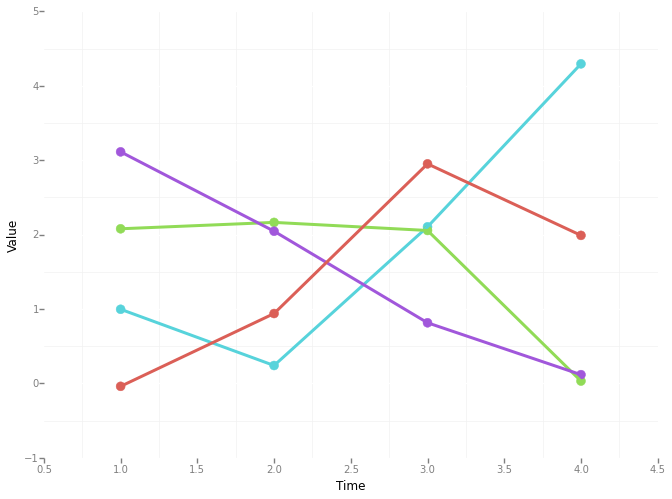

<ggplot: (303148237)>


In [69]:
# ----------- #
# Test Trajectory Plotting Function & Visual Check of Trajectories
# ----------- #
d1 = MultiNormalDistribution(4, [0.0, 1.0, 3.0,2.0], 
                    [[1.0, 0.1, 0.14,0.2], 
                     [0.8, 1.0, 0.2,0.4], 
                     [0.5, 0.2, 1.0,0.3], 
                     [0.1, 0.3, 0.3,1.0]])

d2 = MultiNormalDistribution(4, [1.0,0.2, 2.0,4.5], 
                    [[1.0, 0.3, 0.5,0.0], 
                     [0.5, 1.0, 0.2, 0.5], 
                     [0.3, 0.4, 1.0, 0.5],
                    [0.3, 0.4, 0.1, 1.0]])

d3 = MultiNormalDistribution(4, [3.0,2.0, 1.0,0.0], 
                    [[1.0, 0.3, 0.5,0.0], 
                     [0.5, 1.0, 0.2, 0.5], 
                     [0.3, 0.4, 1.0, 0.5],
                    [0.3, 0.4, 0.1, 1.0]])
    
data1 = d1.sampleSet(300)
data2 = d2.sampleSet(100)
data3 = d3.sampleSet(100)

# print np.array(data1)
data3= np.concatenate([data1, data2, data3], axis=0)
outs_1 = GBFMM(ng=4, data=data3, s=0)
plot_traj(outs_1)

# 4) Application and Comparison

### Data
To apply this algorithm to a real problem on real data, I examine the Adjudicated Toronto Youth Data. The data include the number of criminal court appearances by 378 youth in Toronto. Each individual has 5 years of data, where each row contains the number of unique court contacts per year for an individual from the age of 18 to 23.

### Comparison
I compare the EM algorithm approach to a Bayesian finite mixture written in the probabilistic programming language STAN, and called by the python module pystan. This approach using MCMC instead of the MLE approach based on the EM algorithm.

In [74]:
%%R
load("/Data/TO1adj.rda")
load("/Data/TO1stan.rda")
TO1adj <- TO1adj[,10:15]
# Data are located in GitHub Repo in Data Directory

In [75]:
TO1adj = %R TO1adj
TO1stan = %R TO1stan
TO1adj = np.array(TO1adj)

In [76]:
outs = GBFMM(2,TO1adj)

Step 1: log likelihood: -5874.69620147   (diff=-5873.69620147)
Step 2: log likelihood: -5782.28775531   (diff=92.408446164)
Step 3: log likelihood: -5735.37279974   (diff=46.9149555604)
Step 4: log likelihood: -5725.59455795   (diff=9.77824179596)
Step 5: log likelihood: -5721.56812432   (diff=4.02643363104)
Step 6: log likelihood: -5709.27463866   (diff=12.2934856551)
Step 7: log likelihood: -5677.63503708   (diff=31.6396015824)
Step 8: log likelihood: -5577.26677048   (diff=100.368266603)
Step 9: log likelihood: -5360.78622798   (diff=216.480542493)
Step 10: log likelihood: -5161.11428695   (diff=199.671941031)
Step 11: log likelihood: -4949.69647743   (diff=211.417809524)
Step 12: log likelihood: -4864.92774278   (diff=84.7687346443)
Step 13: log likelihood: -4837.29260321   (diff=27.63513957)
Step 14: log likelihood: -4831.85916386   (diff=5.43343935681)
Step 15: log likelihood: -4830.13973582   (diff=1.71942804021)
Step 16: log likelihood: -4829.07981934   (diff=1.05991648075)
Ste

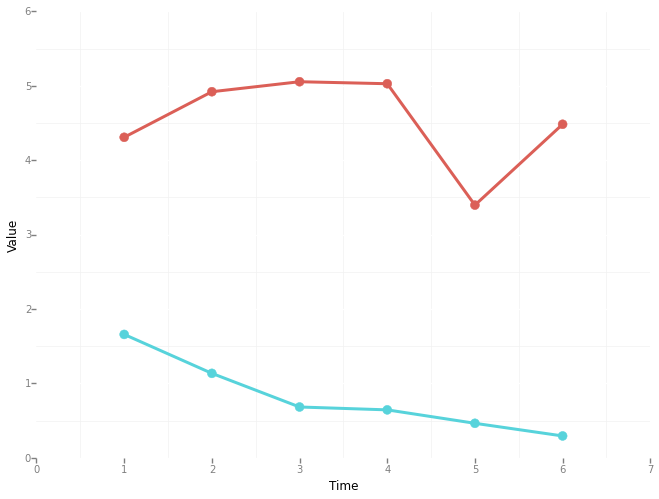

<ggplot: (308464657)>


In [77]:
plot_traj(outs)

### Results
The EM based finite mixture algorithm has identified two clustered trajectories. The red shows a cluster of youth who are coming into contact with criminal courts frequently over this five year period. The blue line shows a low risk trajectory.

Now let's try the MCMC approach:

In [97]:
model_code = """
data {
  int<lower=1> K;                                                  # K components
  int<lower=1> N;                                                  # N observations
  real y[N];                                                       # variable of interest
}
parameters {
  simplex[K] theta;                                                # mixing proportions
  simplex[K] mu_prop;
  real mu_loc;
  real<lower=0> mu_scale;
  real<lower=0> sigma[K];                                          # sds of the components
}
transformed parameters {
  ordered[K] mu;
  mu <- mu_loc + mu_scale * cumulative_sum(mu_prop);               # means of the components
}
model {
  // prior
  mu_loc ~ cauchy(0,5);
  mu_scale ~ cauchy(0,5);
  sigma ~ cauchy(0,5);
  // likelihood
  {
    real ps[K];
    vector[K] log_theta;
    log_theta <- log(theta);
    for (n in 1:N) {
      for (k in 1:K) {
        ps[k] <- log_theta[k]
                 + normal_log(y[n],mu[k],sigma[k]);
      }
      increment_log_prob(log_sum_exp(ps));
    }
  }
}
"""

dat = {
    'K': 2,
    'N': len(np.array(TO1stan)),
    'y': np.array(TO1stan),
}

fit = pystan.stan(model_code=model_code, data=dat, iter=1000, chains=2)

In [98]:
print fit

Inference for Stan model: anon_model_0ea983c07018240174b20728e647dd40.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[0]     0.35  1.9e-3   0.03   0.29   0.33   0.35   0.37   0.41  257.0    1.0
theta[1]     0.65  1.9e-3   0.03   0.59   0.63   0.65   0.67   0.71  257.0    1.0
mu_prop[0]   0.38    0.02    0.2   0.02   0.21   0.38   0.54   0.72   79.0    1.0
mu_prop[1]   0.62    0.02    0.2   0.28   0.46   0.62   0.79   0.98   79.0    1.0
mu_loc        0.2    0.18   1.53  -3.61  -0.67   0.61   1.43   1.98   74.0    1.0
mu_scale     4.08    0.18   1.53   2.29   2.86   3.68   4.95   7.86   74.0    1.0
sigma[0]     0.25  1.4e-3   0.02    0.2   0.23   0.24   0.26   0.29  268.0    1.0
sigma[1]     0.44  1.7e-3   0.03   0.39   0.42   0.44   0.45   0.49  244.0    1.0
mu[0]        2.02  1.5e-3   0.03   1.97   2.01   2.02   2.04   2.08  306.0 

### Results
While similar inferences can be drawn from this MCMC method, and I would argue in many cases the Bayesian results are more robust, convergence time is much slower. For mixture model problems where the underlying structure is not incredibly complex, the EM algorithm employed by the Group-Based Finite Mixture Model may be more practical.